In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import pytz
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import plotly
import plotly.graph_objs as go
from plotly.offline import plot
from plotly import tools


In [2]:
# Read trip data
Data_X = pd.read_csv('UberPriceTrackX.csv')
Data_Pool = pd.read_csv('UberPriceTrackPool.csv')
Data_X.head()

,Time,None,Price,Duration,Distance,Wait_Time
0,2018-11-08 17:51:51.493805,1541699632,8.71,960,3.27,4
1,2018-11-08 17:55:56.128564,1541699877,8.71,960,3.27,3
2,2018-11-08 17:56:57.918118,1541699939,8.71,960,3.27,2
3,2018-11-08 17:57:59.659881,1541700001,8.71,960,3.27,2
4,2018-11-08 17:59:01.625413,1541700063,8.71,960,3.27,4


In [17]:
def time_converter(Data):
    
    """
    Converts given time from UTC to specified timezone
    """
    date = list(Data['Time'])

    converted_date = []
    
    for date in date:
        converted_date.append(convert_time(date))

    Data['Converted Time'] = converted_date
    Data_df = Data[['Time','Converted Time','Price','Duration','Distance','Wait_Time']]
    
    return Data_df, converted_date

def convert_time(dt):
    
    """
    Converts given time from UTC to specified timezone
    Also removes pytz timezone information as to not mess with plotting
    """
    
    date_format='%Y-%m-%d %H:%M:%S.%f'

    date_current_utc = datetime.strptime(dt, date_format)
    date_current_utc = pytz.utc.localize(date_current_utc).astimezone(pytz.UTC)
    
    date_changed = date_current_utc.astimezone(timezone('US/Pacific'))
    
    # Remove timezone information cause it fucks with the plotting
    date_changed = date_changed.replace(tzinfo=None)
    return date_changed

In [18]:
Data_X, Converted_Date_X = time_converter(Data_X)
Data_Pool, Converted_Date_Pool = time_converter(Data_Pool)

In [20]:
# Dynamic Graphing for zoomable plots with overlays

trace_high = go.Scatter(
    x=Converted_Date_X,
    y=Data_X['Price'],
    name = "Uber X",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_low = go.Scatter(
    x=Converted_Date_Pool,
    y=Data_Pool['Price'],
    name = "UberPool",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title='Uber Price Comparison',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.plot(fig, filename = "Price_Comparison_Plot.html")

'file:///Users/ziningw/Desktop/UC Berkeley/CIVENG 262/Project/Project Folder/Price_Comparison_Plot.html'

Text(0,0.5,'Trip Price ($)')

<Figure size 432x288 with 0 Axes>

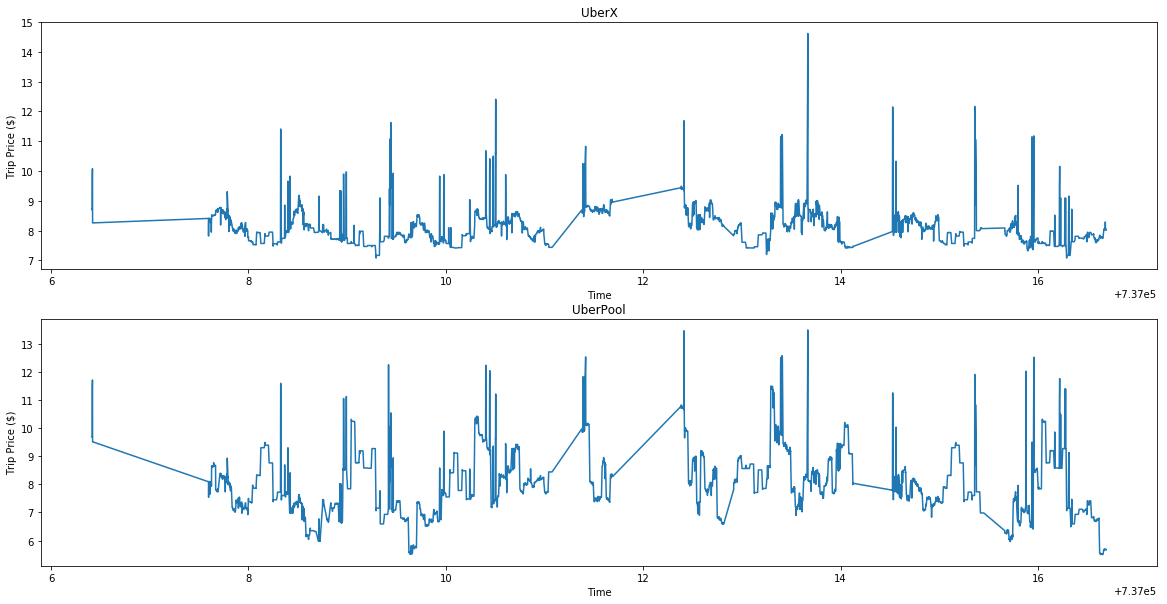

In [22]:
# Simpler inline 
plt.subplots_adjust(hspace = 2)

f = plt.figure(figsize=(20,10))

ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

dates_X = matplotlib.dates.date2num(Data_X['Converted Time'].tolist())
ax.plot(dates_X, Data_X['Price'])
ax.set_title("UberX")
ax.set_xlabel('Time')
ax.set_ylabel('Trip Price ($)')

dates_Pool = matplotlib.dates.date2num(Data_Pool['Converted Time'].tolist())
ax2.plot(dates_Pool, Data_Pool['Price'])
ax2.set_title("UberPool")
ax2.set_xlabel('Time')
ax2.set_ylabel('Trip Price ($)')